## Imports

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms
import gc

import random
from tqdm import tqdm
import numpy as np
import cv2
import matplotlib.pyplot as plt
from collections import namedtuple, deque
import time
from simulation import Simulator, coordinate

## Simulator Setup

In [25]:
def reset_sim():
    # Units are pixels for resolution, degrees for fov, degrees for angle, and pixels for height.
    img_size = (128, 72)
    cameraSettings = {
        # "resolution": (1920, 1080),
        "resolution": img_size,
        "fov": {"diagonal": 77}, # realsense diagonal fov is 77 degrees IIRC
        "angle": {"roll": 0, "pitch": 0, "yaw": 0}, # don't go too crazy with these, my code should be good up to like... 45 degrees probably? But the math gets unstable
        # "angle": {"roll": 13, "pitch": 30, "yaw": 30}, # don't go too crazy with these, my code should be good up to like... 45 degrees probably? But the math gets unstable
        "height": 66 # 8 pixels/inch - represents how high up the camera is relative to the road
    }

    mapParameters = {
        "loops": 1,
        "size": (6, 6),
        "expansions": 5,
        "complications": 4
    }

    # Can also pass car parameters for max/min speed, etc
    carParameters = {
        "wheelbase": 6.5, # inches, influences how quickly the steering will turn the car.  Larger = slower
        "maxSteering": 30.0, # degrees, extreme (+ and -) values of steering
        "steeringOffset": 0.0, # degrees, since the car is rarely perfectly aligned
        "minVelocity": 0.0, # pixels/second, slower than this doesn't move at all.
        "maxVelocity": 480.0, # pixels/second, 8 pixels/inch, so if the car can move 5 fps that gives us 480 pixels/s top speed
    }

    sim = Simulator(cameraSettings=cameraSettings)

    startLocations = np.array([[0,1], [0,2], [0,3], [0,4], [0,5], [0,6], [0,7], [1,0], [1,1], [1,4], [1,7], [2,2], [2,3], [1,4], [2,5], [2,6], [2,0], [5,1], [3,2], [2,4], [5,5], [5,6], [2,7], [3,0], [7,1], [4,2], [7,3], [5,4], [6,5], [3,7], [4,0], [5,2], [7,4], [7,5], [4,7], [5,0], [7,2], [5,7], [6,0]])
    startLoc = random.randint(0, 38)

    sim.start(mapSeed='real', mapParameters=mapParameters, carParameters=carParameters, startPoint=(int(startLocations[startLoc, 0]),int(startLocations[startLoc, 1]),0,0))
    # sim.start(mapSeed='real', mapParameters=mapParameters, carParameters=carParameters, startPoint=(0,4,0,0))
    
    where, facing = sim.RealSense.parent.ackermann.pose()
    initial_img = sim.RealSense.camera.getImage(where, facing)
    return sim, initial_img

From here, the API for using the simulation is as follows. Steps the entire simulation, returns image, reward from sim.getReward() and a done bool (and we can change what 'done' means. Currently its if reward is negative):

```python
frame, reward, done = sim.step(steer, speed, display=False) 
```

In order to reset the simulation, you just need to reconstruct the sim object and start it, using the reset_sim() function above.

# DQN

Deep Q-Network (https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf) is a Q-learning algorithm that learns values for state-action pairs.

Actions are sampled according to an $\epsilon-greedy$ policy to help with exploration of the state space. Every time an action is sampled, the agent chooses a random action with $\epsilon$ probability. Otherwise, the agent selects the action with the highest Q-value for a state. $\epsilon$ decays over time according to $\epsilon \gets \epsilon * epsilon\_decay$.

Tuples of state, action, reward, next_state, and terminal $(s,a,r,s',d)$ are collected during training. Every $learn\_frequency$ steps $sample\_size$ tuples are sampled and made into 5 tensors tensors of states, actions, rewarads, next_states, and terminals.

The loss for a batch of size N is given below.

$Loss=\frac{1}{N}\sum \bigg(Q(s,a) - (r + \gamma \underset{a'\sim A}{max} \hat{Q}(s',a')(1-d))\bigg)^2 $

Loss is calculated and used to update the Q-Network. The target network $\hat{Q}$ begins as a copy of the Q network but is not updated by the optimizer. Every $target\_update$ steps, the target network is updated with the parameters of the Q-Network. This process is a type of bootstrapping.

In [26]:
# Q-Value Network
class QNetwork(nn.Module):
  def __init__(self, action_size, in_channels=3, cnn_outchannels=1, hidden_size=128):
    super().__init__()
  
    self.cnn = nn.Sequential(
                            nn.Conv2d(in_channels=in_channels, out_channels=cnn_outchannels*16, kernel_size=3, stride=1, padding=1),
                            nn.ReLU(),
                            nn.Conv2d(in_channels=cnn_outchannels*16, out_channels=cnn_outchannels*32, kernel_size=3, stride=1, padding=1),
                            nn.ReLU(),
                            nn.Conv2d(in_channels=cnn_outchannels*32, out_channels=cnn_outchannels, kernel_size=3, stride=1, padding=1),
                            nn.ReLU()
                            )

    self.controller = nn.Sequential(
                            nn.Linear(128*72, hidden_size),
                            nn.ReLU(),
                            nn.Linear(hidden_size, action_size)
                            )

    
  def forward(self, img_batch):
    """Estimate q-values given image
    """
    cnn_output = self.cnn(img_batch.permute([0, 3, 1, 2]))
    return self.controller(cnn_output.view(cnn_output.size(0), -1)) # Have to resize the output of the cnn to be accepted  by the linear layer

In [27]:
Transition = namedtuple('Transition',
                        ('frame', 'action', 'next_frame', 'reward'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

class TrainingStats():
    def __init__(self, SAVE_FREQUENCY, SAVE_REWARD_THRESHOLD=25):
        self.reward_results_dqn = []
        self.episode_lengths = []
        self.global_steps = 0
        self.episodes = 0
        self.cum_reward = 0
        self.curr_episode_len = 0
        self.avg_reward = 0
        self.prev_avg_reward = SAVE_REWARD_THRESHOLD
        self.SAVE_REWARD_THRESHOLD = SAVE_REWARD_THRESHOLD
        self.SAVE_FREQUENCY = SAVE_FREQUENCY

    def end_episode(self):
        """
        Returns True if we want to save the network
        """
        flag = False
        self.reward_results_dqn.append(self.cum_reward)
        self.episode_lengths.append(self.curr_episode_len)

        # Save the network if save_frequency steps has passed and it is better than the previous avg_reward
        if (self.global_steps % self.SAVE_FREQUENCY == 0): # and self.global_steps > self.SAVE_FREQUENCY:
            # avg_reward = sum(self.reward_results_dqn[:self.SAVE_FREQUENCY]) / self.SAVE_FREQUENCY # get the average reward for the last SAVE_FREQUENCY steps

            # if (avg_reward > self.prev_avg_reward + self.SAVE_REWARD_THRESHOLD):
            #     print(f"{self.global_steps} steps completed. Average Reward: {avg_reward} > Previous Average: {self.prev_avg_reward}. Saving Model")
            # self.prev_avg_reward = avg_reward
            flag = True
            
        self.episodes += 1
        self.cum_reward = 0  # Track cumulative reward per episode
        self.curr_episode_len = 0

        return flag

    def end_frame(self, reward):
        self.cum_reward += reward
        self.global_steps += 1
        self.curr_episode_len += 1

    def see_results(self):
        plt.subplot(111)
        plt.plot(self.episode_lengths)
        plt.xlabel("Episode Number")
        plt.ylabel("Steps in Episode")
        plt.title("Episode Lengths")

        print(self.get_printout())


    def get_printout(self):
        return 'Global Steps: {:5d} Episodes: {:5d} Episode Length: {:4d} Reward: {:3.2f}'.format(self.global_steps, self.episodes, self.curr_episode_len, self.cum_reward)



def validate_model(trained_model, action_space, pause_time=0.001, val_episodes=100, display=False):
    episode_lengths = []

    for val_episode in range(1, val_episodes):
        # Reset environment
        sim, frame = reset_sim()
        frame = torch.tensor(frame, dtype=torch.float32).unsqueeze(0).cuda()

        done = False
        episode_length = 0

        # Begin episode
        while not done: 
            with torch.no_grad():
                action_idx = trained_model(frame).max(1)[1].view(1, 1)

            # Take step
            observation, reward, done = sim.step(steer=action_space[action_idx], speed=1.5, display=display, validate=False)
            next_frame = torch.tensor(observation, dtype=torch.float32).unsqueeze(0).cuda()

            frame = next_frame  # Set current frame
            episode_length += 1
            time.sleep(pause_time)
            
        episode_lengths.append(episode_length)
        episode_length = 0

    plt.plot(episode_lengths)

In [28]:
def get_action_dqn(network, frame, epsilon, epsilon_decay, action_size, global_steps, REPLAY_SIZE):
  """Select action according to e-greedy policy and decay epsilon
  """
  if random.uniform(0., 1.) < max(0.1, epsilon) or global_steps < REPLAY_SIZE:
    action = random.randint(0,action_size-1) #randint 0-action_space size corresponding to [-30,-20,-10,0,10,20,30] degrees
    action = torch.tensor(action).view(1,1)
  else:
    with torch.no_grad():
      action = network(frame).max(1)[1].view(1, 1)
  return action.cuda(), epsilon*epsilon_decay

  
def learn_dqn(memory_buffer, batch_size, optim, q_network, target_network, gamma, episode, target_update):
  """Update Q-Network according to DQN Loss function
     Update Target Network every target_update global steps
  """
  transitions = memory_buffer.sample(batch_size)
  batch = Transition(*zip(*transitions))

  non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_frame)), dtype=torch.bool).cuda()
  non_final_next_states = torch.cat([s for s in batch.next_frame
                                          if s is not None])

  frame_batch = torch.cat(batch.frame)
  action_batch = torch.cat(batch.action).long()
  reward_batch = torch.cat(batch.reward)

  Q = q_network(frame_batch).gather(1, action_batch)

  Q_hat = torch.zeros(batch_size).cuda()
  with torch.no_grad():
      Q_hat[non_final_mask] = target_network(non_final_next_states).max(1)[0]

  b = reward_batch + gamma*Q_hat
  Q = torch.squeeze(Q)
  
  loss = F.mse_loss(Q, b)
  optim.zero_grad()
  loss.backward()

  torch.nn.utils.clip_grad_value_(q_network.parameters(), 100)
  optim.step()

  if episode % target_update == 0:
    target_network.load_state_dict(q_network.state_dict())


### Main

In [29]:
def dqn_main(ts, episodes, action_space, lr, EPSILON_DECAY, START_TRAINING, MAX_EPISODE_LENGTH, LEARN_FREQUENCY, TARGET_UPDATE, BATCH_SIZE, SAVE_PATH, pretrained_model=None):
  gc.collect()
  torch.cuda.empty_cache()

  # Init networks
  if pretrained_model == None:
    q_network = QNetwork(action_size=len(action_space)).cuda()
  else:
    q_network = pretrained_model

  target_network = QNetwork(action_size=len(action_space)).cuda()
  target_network.load_state_dict(q_network.state_dict()) # copy q_network into target_network

  optim = torch.optim.Adam(q_network.parameters(), lr=lr)  # Init optimizer
  loop = tqdm(total=episodes, position=0, leave=False)
  memory_buffer = ReplayMemory(45000)  # Init episode replay buffer

  # HyperParameters that shouldn't change too much
  epsilon = 1
  CAR_SPEED = 1.5
  gamma = 0.99
  REPLAY_SIZE = 1000 # Don't let the network pick actions until after this many global steps

  for episode in range(1, episodes):
    sim, frame = reset_sim()     # Reset environment
    frame = torch.tensor(frame, dtype=torch.float32).unsqueeze(0).cuda()
    done = False

    while not done and ts.curr_episode_len < MAX_EPISODE_LENGTH:
      action_idx, epsilon = get_action_dqn(q_network, frame, epsilon, EPSILON_DECAY, len(action_space), ts.global_steps, REPLAY_SIZE) # Select e-greedy action

      observation, reward, done = sim.step(steer=action_space[action_idx], speed=CAR_SPEED, display=False)       # Take step in the environment

      next_frame = None if done else torch.tensor(observation, dtype=torch.float32).unsqueeze(0).cuda()
      reward = torch.tensor([reward]).cuda()

      # Store step in replay bufferimg
      memory_buffer.push(frame, action_idx, next_frame, reward)
      frame = next_frame                        # Set current frame
      ts.end_frame(reward.item())

      if (ts.global_steps > START_TRAINING) and (ts.global_steps % LEARN_FREQUENCY == 0):
        learn_dqn(memory_buffer, BATCH_SIZE, optim, q_network, target_network, gamma, episode, TARGET_UPDATE)     # Train

    loop.update(1)
    a = torch.cuda.memory_allocated(0)
    r = torch.cuda.memory_reserved(0)
    loop.set_description('{} All Mem: {:.2f}, Res Mem: {:.2f}'.format(ts.get_printout(), a/1e9, r/1e9))

    if ts.end_episode():
      torch.save(q_network, f'{SAVE_PATH}{episode}.pt')
  
  return q_network, ts

In [30]:
def save_model(model, SAVE_PATH):
    torch.save(model, f'{SAVE_PATH}.pt')

def load_model(action_size, PATH):
    model = QNetwork(action_size)
    model = torch.load(PATH)
    model.eval()
    return model

In [31]:
# Hyper parameters
########################################################################
ts = TrainingStats(SAVE_FREQUENCY=2500)
episodes = 25000
action_space = [-30,0,30]                               # CHANGED
lr = 0.00025
EPSILON_DECAY = .999995                                

START_TRAINING = 200
MAX_EPISODE_LENGTH = 10000                                         
LEARN_FREQUENCY = 3 
                              
TARGET_UPDATE = 2000
BATCH_SIZE = 32                                         
SAVE_PATH = './rl_models/3actions_base_'

In [32]:
# Train Model
#############################################################################
start = time.time()
trained_model, ts = dqn_main(ts, episodes, action_space, lr, EPSILON_DECAY, START_TRAINING, MAX_EPISODE_LENGTH, LEARN_FREQUENCY, TARGET_UPDATE, BATCH_SIZE, SAVE_PATH, 
                            pretrained_model=None)
end = time.time()
save_model(trained_model, f'{SAVE_PATH}finalmodel')
ts.see_results()
print(f"Total Training Time: {(end-start)/60} min")
##############################################################################

Global Steps: 181118 Episodes:  3920 Episode Length:  131 Reward: 130.00 All Mem: 5.06, Res Mem: 5.50:  16%|█▌        | 3921/25000 [27:04<4:00:12,  1.46it/s]

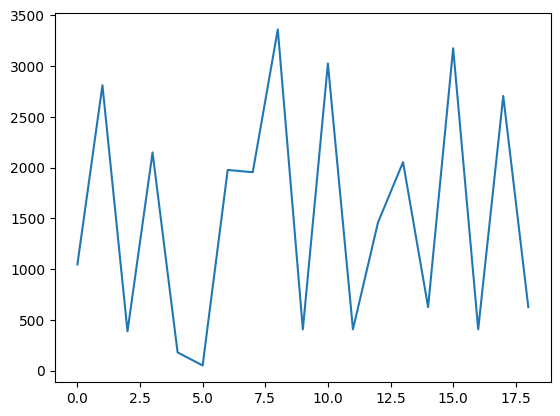

In [23]:
# Validate Model
# model = load_model(2, './rl_models/5actions_learnFreq_2169.pt')
# model = load_model(2, './rl_models/working_model.pt')

action_space = [-30, 30]
model = load_model(len(action_space), './rl_models/working_2actmodel.pt')


validate_model(model, action_space, pause_time=0.0, val_episodes=20, display=True)

In [ ]:
"""
Next Steps:
    - speeding up the tutorial code wouldn't hurt
    - Get it to train on a more complicated (random?) map

Next Next Steps:
    - apply control input for 2+ frames?
    - we are still not stacking images as input to the network

"""

: 